# Load the stored .npy files to check CAMs
and the dicts

In [1]:
# Package installations
from IPython.utils import io
with io.capture_output() as captured:
    !pip install gdown

In [2]:
!pip install --upgrade Pillow

Requirement already up-to-date: Pillow in /usr/local/lib/python3.7/dist-packages (8.2.0)


In [3]:
with io.capture_output() as captured:
  from google.colab import drive 
  drive.mount('/content/drive')
%cd /content/drive/MyDrive/MAI/thesis/source

/content/drive/MyDrive/MAI/thesis/source


In [4]:
import numpy as np
import sys
sys.path.append('/content/drive/MyDrive/MAI/thesis/source/OAA')
sys.path.append('/content/drive/MyDrive/MAI/thesis/source/SEAM')

import torch
import os.path
import scipy.misc
import cv2
import random, tqdm

CAT_LIST = ['dyed-lifted-polyp',
            'dyed-resection-margins',
            'esophagitis',
            'normal-cecum',
            'normal-pylorus',
            'normal-z-line', 
            'polyps',
            'ulcerative-colitis']

CAT_LIST = ['aeroplane', 'bicycle', 'bird', 'boat',
        'bottle', 'bus', 'car', 'cat', 'chair',
        'cow', 'diningtable', 'dog', 'horse',
        'motorbike', 'person', 'pottedplant',
        'sheep', 'sofa', 'train',
        'tvmonitor']

In [5]:
%cd SEAM/check_crfs

/content/drive/MyDrive/MAI/thesis/source/SEAM/check_crfs


In [6]:
!ls

attention	 results_cam	   results_crf_24.0  results_seg
check_crf.ipynb  results_cam_pred  results_crf_4.0


In [7]:
import imageio
import torch.nn as nn
import torch.nn.functional as F
import argparse
import torchvision
from torchvision import models, transforms
from torch.utils.data import DataLoader
from utils.LoadData import test_data_loader
from utils.Restore import restore
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
import utils.imutils as imutils
import kvasirv2.data

colormaps = ['#000000', '#7F0000', '#007F00', '#7F7F00', '#00007F', '#7F007F', '#007F7F', '#7F7F7F', '#3F0000', '#BF0000', '#3F7F00',
                      '#BF7F00', '#3F007F', '#BF007F', '#3F7F7F', '#BF7F7F', '#003F00', '#7F3F00', '#00BF00', '#7FBF00', '#003F7F']


In [8]:
data_root = "/content/drive/MyDrive/MAI/thesis/source/VOCdevkit/VOC2012"
la_crf_dir = "results_crf_4.0/"
ha_crf_dir = "results_crf_24.0/"

batch_size = 32
input_size = 256

dataset = 'kvasir'

num_classes = 8
num_workers = 2
out_cam = 'results_cam/'
out_cam_pred = "results_cam_pred/"

# Parameters

In [9]:
from torch.utils.data import Dataset

def load_img_name_list(dataset_path):
    img_gt_name_list = open(dataset_path).read().splitlines()
    img_name_list = [img_gt_name.split(' ')[0][-15:-4] for img_gt_name in img_gt_name_list]
    #img_name_list = img_gt_name_list
    return img_name_list

class VOC12ImageDataset(Dataset):
    def __init__(self, img_name_list_path, voc12_root, transform=None):
        self.img_name_list = load_img_name_list(img_name_list_path)
        self.voc12_root = voc12_root
        self.transform = transform

    def __len__(self):
        return len(self.img_name_list)

    def __getitem__(self, idx):
        name = self.img_name_list[idx]
        img = Image.open(get_img_path(name, self.voc12_root)).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return name, img

class VOC12AffDataset(VOC12ImageDataset):
    def __init__(self, img_name_list_path, label_la_dir, label_ha_dir, cropsize, voc12_root, radius=5,
                 joint_transform_list=None, img_transform_list=None, label_transform_list=None):
        super().__init__(img_name_list_path, voc12_root, transform=None)

        self.label_la_dir = label_la_dir
        self.label_ha_dir = label_ha_dir
        self.voc12_root = voc12_root

        self.joint_transform_list = joint_transform_list
        self.img_transform_list = img_transform_list
        self.label_transform_list = label_transform_list

        self.extract_aff_lab_func = ExtractAffinityLabelInRadius(cropsize=cropsize//8, radius=radius)

    def __len__(self):
        return len(self.img_name_list)

    def __getitem__(self, idx):
        name, img = super().__getitem__(idx)

        label_la_path = os.path.join(self.label_la_dir, name + '.npy')

        label_ha_path = os.path.join(self.label_ha_dir, name + '.npy')

        label_la = np.load(label_la_path, allow_pickle=True).item()
        label_ha = np.load(label_ha_path, allow_pickle=True).item()

        label = np.array(list(label_la.values()) + list(label_ha.values()))
        label = np.transpose(label, (1, 2, 0))

        for joint_transform, img_transform, label_transform \
                in zip(self.joint_transform_list, self.img_transform_list, self.label_transform_list):

            if joint_transform:
                img_label = np.concatenate((img, label), axis=-1)
                img_label = joint_transform(img_label)
                img = img_label[..., :3]
                label = img_label[..., 3:]

            if img_transform:
                img = img_transform(img)
            if label_transform:
                label = label_transform(label)

        no_score_region = np.max(label, -1) < 1e-5
        label_la, label_ha = np.array_split(label, 2, axis=-1)
        label_la = np.argmax(label_la, axis=-1).astype(np.uint8)
        label_ha = np.argmax(label_ha, axis=-1).astype(np.uint8)
        label = label_la.copy()
        label[label_la == 0] = 255
        label[label_ha == 0] = 0
        label[no_score_region] = 255 # mostly outer of cropped region
        label = self.extract_aff_lab_func(label)

        return img, label



class ExtractAffinityLabelInRadius():
    def __init__(self, cropsize, radius=5):
        self.radius = radius

        self.search_dist = []

        for x in range(1, radius):
            self.search_dist.append((0, x))

        for y in range(1, radius):
            for x in range(-radius+1, radius):
                if x*x + y*y < radius*radius:
                    self.search_dist.append((y, x))

        self.radius_floor = radius-1

        self.crop_height = cropsize - self.radius_floor
        self.crop_width = cropsize - 2 * self.radius_floor
        return

    def __call__(self, label):

        labels_from = label[:-self.radius_floor, self.radius_floor:-self.radius_floor]
        labels_from = np.reshape(labels_from, [-1])

        labels_to_list = []
        valid_pair_list = []

        for dy, dx in self.search_dist:
            labels_to = label[dy:dy+self.crop_height, self.radius_floor+dx:self.radius_floor+dx+self.crop_width]
            labels_to = np.reshape(labels_to, [-1])

            valid_pair = np.logical_and(np.less(labels_to, 255), np.less(labels_from, 255))

            labels_to_list.append(labels_to)
            valid_pair_list.append(valid_pair)

        bc_labels_from = np.expand_dims(labels_from, 0)
        concat_labels_to = np.stack(labels_to_list)
        concat_valid_pair = np.stack(valid_pair_list)

        pos_affinity_label = np.equal(bc_labels_from, concat_labels_to)

        bg_pos_affinity_label = np.logical_and(pos_affinity_label, np.equal(bc_labels_from, 0)).astype(np.float32)

        fg_pos_affinity_label = np.logical_and(np.logical_and(pos_affinity_label, np.not_equal(bc_labels_from, 0)), concat_valid_pair).astype(np.float32)

        neg_affinity_label = np.logical_and(np.logical_not(pos_affinity_label), concat_valid_pair).astype(np.float32)

        return torch.from_numpy(bg_pos_affinity_label), torch.from_numpy(fg_pos_affinity_label), torch.from_numpy(neg_affinity_label)


# functions

In [10]:
def colormap(index):
    return mpl.colors.LinearSegmentedColormap.from_list('cmap', [colormaps[0], colormaps[index+1], '#FFFFFF'], 256)

def _crf_with_alpha(orig_img, cam_dict, alpha):
    v = np.array(list(cam_dict.values()))       # change dict to array
    bg_score = np.power(1 - np.max(v, axis=0, keepdims=True), alpha)
    bgcam_score = np.concatenate((bg_score, v), axis=0)
    crf_score = imutils.crf_inference(np.ascontiguousarray(orig_img.astype(np.uint8)), bgcam_score, labels=bgcam_score.shape[0])

    n_crf_al = dict()

    n_crf_al[0] = crf_score[0]
    for i, key in enumerate(cam_dict.keys()):
        n_crf_al[key+1] = crf_score[i+1]

    return n_crf_al

# Load and check the crfs  
SEAM

In [11]:
!pwd
!ls results_crf_4.0

/content/drive/MyDrive/MAI/thesis/source/SEAM/check_crfs
2008_005500.npy  2009_000840.npy  2009_000843.npy  2009_001129.npy


In [12]:
label_la_path = la_crf_dir+'2009_000840.npy'
label_ha_path = ha_crf_dir+'2009_000840.npy'

In [13]:
label_la = np.load(label_la_path, allow_pickle=True).item()
label_ha = np.load(label_ha_path, allow_pickle=True).item()

In [14]:
label_la.keys()

dict_keys([0, 5])

(500, 375)
1.0
1.2074573e-11


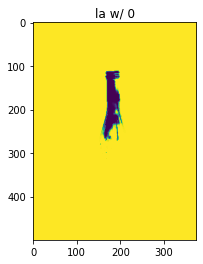

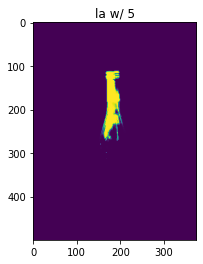

In [15]:
print(label_la[0].shape)     # image shape with bg
print(label_la[0].max())     # 1 and almost 0
print(label_la[0].min())     # 1 and almost 0

for i in label_la.keys():
  plt.figure()
  plt.imshow(label_la[i])
  plt.title(f'la w/ {i}')

(500, 375)
1.0
4.138303e-12


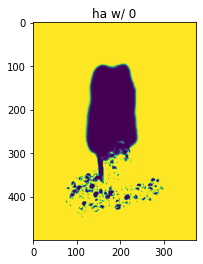

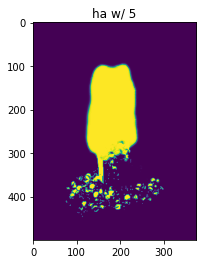

In [16]:
print(label_ha[0].shape)     # image shape with bg
print(label_ha[0].max())     # 1 and almost 0
print(label_ha[0].min())     # 1 and almost 0

for i in label_ha.keys():
  plt.figure()
  plt.imshow(label_ha[i])
  plt.title(f'ha w/ {i}')

In [17]:
label = np.array(list(label_la.values()) + list(label_ha.values()))
label = np.transpose(label, (1, 2, 0))

# Load and check the crfs  2
OAA voc

In [31]:
label_la_path = la_crf_dir+'2008_005500.npy'
label_ha_path = ha_crf_dir+'2008_005500.npy'

In [32]:
label_la = np.load(label_la_path, allow_pickle=True).item()
label_ha = np.load(label_ha_path, allow_pickle=True).item()

In [33]:
label_la.keys()

dict_keys([0, 15])

(500, 375)
1.0
8.3079504e-10


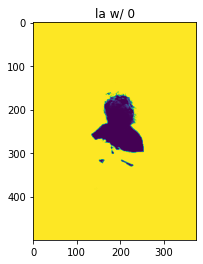

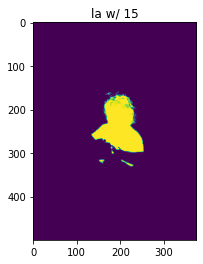

In [34]:
print(label_la[0].shape)     # image shape with bg
print(label_la[0].max())     # 1 and almost 0
print(label_la[0].min())     # 1 and almost 0

for i in label_la.keys():
  plt.figure()
  plt.imshow(label_la[i])
  plt.title(f'la w/ {i}')

(500, 375)
1.0
5.8075827e-12


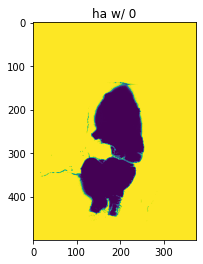

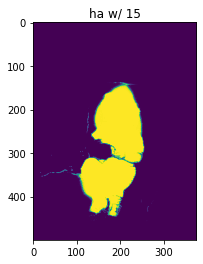

In [35]:
print(label_ha[0].shape)     # image shape with bg
print(label_ha[0].max())     # 1 and almost 0
print(label_ha[0].min())     # 1 and almost 0

for i in label_ha.keys():
  plt.figure()
  plt.imshow(label_ha[i])
  plt.title(f'ha w/ {i}')

In [36]:
label = np.array(list(label_la.values()) + list(label_ha.values()))
label = np.transpose(label, (1, 2, 0))

# Load and check the cams

max:  0.99999547 , min:  -0.024481388 , shape:  (500, 375)


Text(0.5, 1.0, 'CAM')

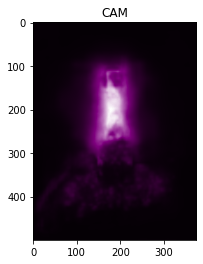

In [24]:
cam_path = out_cam+'2009_000840.npy'
cam = np.load(cam_path, allow_pickle=True).item()
print('max: ', cam[4].max(),', min: ', cam[4].min(), ', shape: ', cam[4].shape)
plt.imshow(cam[4], cmap=colormap(4))
plt.title('CAM')

max:  0.99999356 , min:  -0.03578839 , shape:  (433, 500)


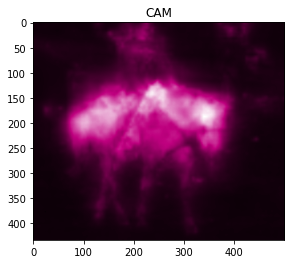

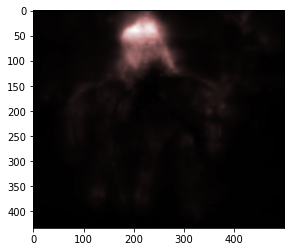

In [42]:
cam_path = out_cam+'2009_000843.npy'
cam = np.load(cam_path, allow_pickle=True).item()
print('max: ', cam[12].max(),', min: ', cam[12].min(), ', shape: ', cam[12].shape)

plt.imshow(cam[12], cmap=colormap(12))
plt.title('CAM')
plt.figure()
plt.imshow(cam[14], cmap=colormap(14))
# for human and horse classes

In [26]:
list(cam.values())

[array([[0.01090823, 0.01109861, 0.01129643, ..., 0.01008911, 0.00980757,
         0.00952102],
        [0.0110193 , 0.01126516, 0.01152153, ..., 0.01092115, 0.01064274,
         0.01035869],
        [0.01121483, 0.01151928, 0.01184044, ..., 0.01178516, 0.01151121,
         0.0112303 ],
        ...,
        [0.00894171, 0.00912417, 0.00929462, ..., 0.01229639, 0.01348562,
         0.01459698],
        [0.00915278, 0.009465  , 0.00976151, ..., 0.01383733, 0.01535823,
         0.01679655],
        [0.00931232, 0.00975616, 0.01018244, ..., 0.01531289, 0.01716073,
         0.01892365]], dtype=float32),
 array([[0.00717344, 0.00707659, 0.00697659, ..., 0.00490094, 0.00484966,
         0.00483308],
        [0.00712693, 0.00703707, 0.00694508, ..., 0.0048845 , 0.00481431,
         0.00477977],
        [0.00703898, 0.00695713, 0.00687519, ..., 0.00489407, 0.0048031 ,
         0.00474964],
        ...,
        [0.00174418, 0.00166292, 0.00157859, ..., 0.00285773, 0.00291962,
         0.0029778 

15 0
Unique numbers in cam pred:  [ 0 13 15]
5 0
Unique numbers in cam pred:  [0 5]


Text(0.5, 1.0, 'CAM pred')

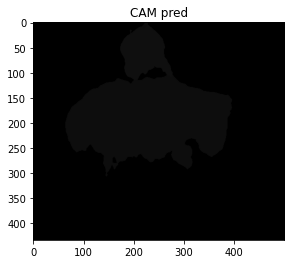

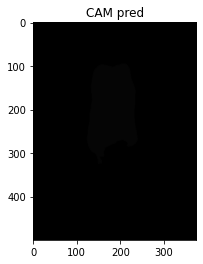

In [27]:
cam_pred_path = out_cam_pred+'2009_000843.png'
img = Image.open(cam_pred_path).convert("RGB")
print(np.max(img), np.min(img))
print('Unique numbers in cam pred: ', np.unique(img))
plt.imshow(img)
plt.title('CAM pred')

cam_pred_path = out_cam_pred+'2009_000840.png'
img = Image.open(cam_pred_path).convert("RGB")
print(np.max(img), np.min(img))
print('Unique numbers in cam pred: ', np.unique(img))
plt.figure()
plt.imshow(img)
plt.title('CAM pred')


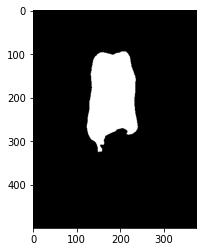

In [28]:
img_arr = np.array(img)
img_arr[img_arr == 5] = 255
plt.imshow(img_arr)

max:  1.0246329 , min:  -0.018390596 , shape:  (500, 375)


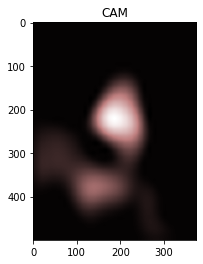

In [37]:
cam_path = out_cam+'2008_005500.npy'
cam = np.load(cam_path, allow_pickle=True).item()
for i in cam.keys():
  print('max: ', cam[i].max(),', min: ', cam[i].min(), ', shape: ', cam[i].shape)
  plt.figure()
  plt.imshow(cam[i], cmap=colormap(i))
  plt.title('CAM')

In [38]:
cam

{14: array([[-9.999901e-06, -9.999901e-06, -9.999901e-06, ..., -9.999901e-06,
         -9.999901e-06, -9.999901e-06],
        [-9.999901e-06, -9.999901e-06, -9.999901e-06, ..., -9.999901e-06,
         -9.999901e-06, -9.999901e-06],
        [-9.999901e-06, -9.999901e-06, -9.999901e-06, ..., -9.999901e-06,
         -9.999901e-06, -9.999901e-06],
        ...,
        [-9.999901e-06, -9.999901e-06, -9.999901e-06, ..., -9.999901e-06,
         -9.999901e-06, -9.999901e-06],
        [-9.999901e-06, -9.999901e-06, -9.999901e-06, ..., -9.999901e-06,
         -9.999901e-06, -9.999901e-06],
        [-9.999901e-06, -9.999901e-06, -9.999901e-06, ..., -9.999901e-06,
         -9.999901e-06, -9.999901e-06]], dtype=float32)}

# Check OAA voc

In [29]:
label_la_path = '/content/2007_000039.npy'
label_ha_path = '/content/2007_000039(1).npy'

In [30]:
label_la = np.load(label_la_path, allow_pickle=True).item()
label_ha = np.load(label_ha_path, allow_pickle=True).item()

FileNotFoundError: ignored

In [ ]:
label_la.keys()

In [ ]:
print(label_la[0].shape)     # image shape with bg
print(label_la[1].max())     # 1 and almost 0
plt.imshow(label_la[0])
plt.title('la')
plt.figure()
plt.imshow(label_la[1])

In [ ]:
print(label_ha[0].shape)     # image shape with bg
print(label_ha[1].max())     # 1 and almost 0
plt.imshow(label_ha[0])
plt.title('ha')
plt.figure()
plt.imshow(label_ha[15])

In [ ]:
label = np.array(list(label_la.values()) + list(label_ha.values()))
label = np.transpose(label, (1, 2, 0))
label

# Load and check the cams

In [ ]:
cam

In [ ]:
cam_path = '/content/2007_000039(2).npy'
cam = np.load(cam_path, allow_pickle=True).item()
print('max: ', cam[14].max(),', min: ', cam[14].min(), ', shape: ', cam[14].shape)
plt.imshow(cam[14], cmap=colormap(14))
plt.title('CAM')

In [ ]:
cam_path = out_cam+'2009_000843.npy'
cam = np.load(cam_path, allow_pickle=True).item()
print('max: ', cam[12].max(),', min: ', cam[12].min(), ', shape: ', cam[12].shape)

plt.imshow(cam[12], cmap=colormap(12))
plt.title('CAM')
plt.figure()
plt.imshow(cam[14], cmap=colormap(14))
# for human and horse classes

In [ ]:
list(cam.values())

# Check kvasir

In [ ]:
%cd /content/drive/MyDrive/MAI/thesis/source/OAA/results_kvasir/
!ls
%cd exp4

In [ ]:
out_cam

In [ ]:
cam_path = out_cam+'6dea5840-12c4-4a09-9a05-53f5ca7c.npy'
cam = np.load(cam_path, allow_pickle=True).item()
print('max: ', cam[0].max(),', min: ', cam[0].min(), ', shape: ', cam[0].shape)
plt.imshow(cam[0], cmap=colormap(0))
plt.title('CAM')

In [ ]:
la_crf_dir

In [ ]:
label_la_path = 'results_crf/_4.0/6dea5840-12c4-4a09-9a05-53f5ca7c.npy'
label_ha_path = 'results_crf/_24.0/6dea5840-12c4-4a09-9a05-53f5ca7c.npy'

label_la = np.load(label_la_path, allow_pickle=True).item()
label_ha = np.load(label_ha_path, allow_pickle=True).item()

In [ ]:
label_la[0]

In [ ]:
print(label_la[0].shape)     # image shape with bg
print(label_la[1].max())     # 1 and almost 0
plt.imshow(label_la[0])
plt.title('la')
plt.figure()
plt.imshow(label_la[1])

In [ ]:
print(label_ha[0].shape)     # image shape with bg
print(label_ha[1].max())     # 1 and almost 0
plt.imshow(label_ha[0])
plt.title('ha')
plt.figure()
plt.imshow(label_ha[1])